In [1]:
!pip -q install ultralytics albumentations --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00a 0:00:01


In [11]:
from ultralytics import YOLO
import os, glob, random, shutil, cv2
import numpy as np
import torch
import albumentations as A
from tqdm import tqdm

In [12]:
from pathlib import Path
DATASET_ROOT = Path("/kaggle/input/waste-detection/waste detection data/")
DATASET_ROOT

PosixPath('/kaggle/input/waste-detection/waste detection data')

# Create yaml configuration file

In [13]:
%%writefile /kaggle/working/data.yaml
# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/input/waste-detection/waste detection data/train/images
val: /kaggle/input/waste-detection/waste detection data/valid/images
test: /kaggle/input/waste-detection/waste detection data/test/images

# Number of classes
nc: 7

# Class names
names: ['Aluminium', 'Glass', 'Tag', 'cardboard', 'rigid_plastic', 'soft_plastic', 'wood']

Overwriting /kaggle/working/data.yaml


# Segmentation Visualization

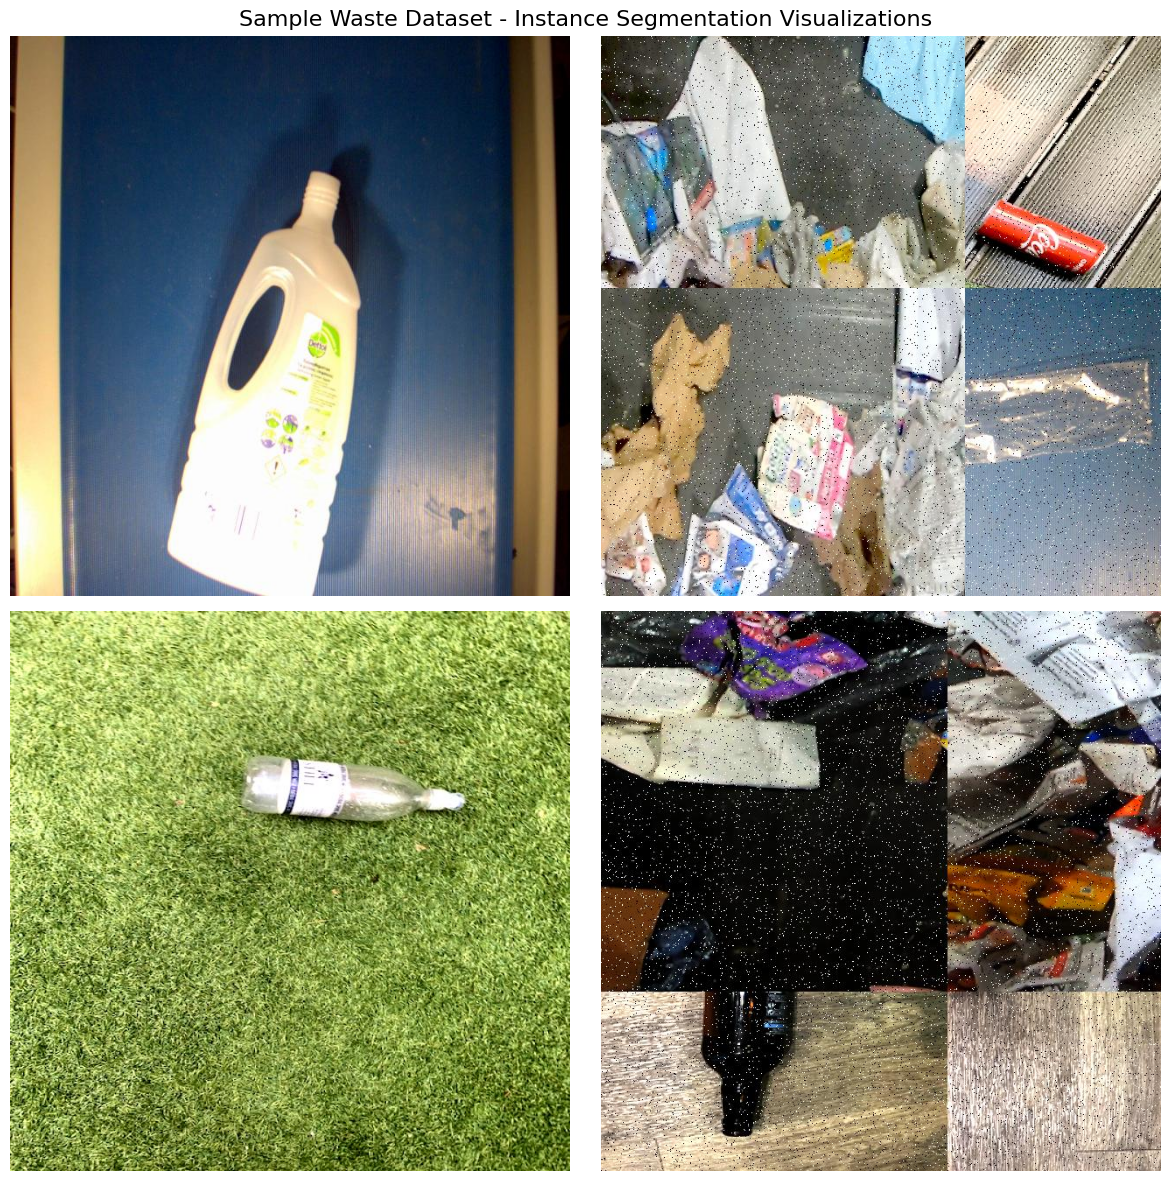

In [14]:
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# YOLOv12 Instance Segmentation Visualization (2x2 Grid)
# ============================================================

# Paths
image_dir = DATASET_ROOT / "train/images"
label_dir = DATASET_ROOT / "train/labels"

# Get random sample of 4 images
image_files = random.sample(os.listdir(image_dir), 4)

def visualize_image(img_path, label_path, class_name="waste"):
    """Visualize one image with segmentation masks or bboxes."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((100, 100, 3), dtype=np.uint8)

    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            cls_id = int(values[0])
            coords = values[1:]

            # Polygon segmentation
            if len(coords) > 4:
                pts = np.array(coords).reshape(-1, 2)
                pts[:, 0] *= w
                pts[:, 1] *= h
                pts = pts.astype(np.int32)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(overlay, [pts], True, (255,255,255), 2)
                cv2.putText(overlay, f"{class_name}", (pts[0][0], pts[0][1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            else:
                # Bounding box fallback
                xc, yc, bw, bh = coords
                x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
                x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                cv2.putText(overlay, f"{class_name}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return overlay


# Create figure
plt.figure(figsize=(12, 12))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))
    vis = visualize_image(img_path, label_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    #plt.title(f"{img_file}") # remove comment if you want to see the file name
    plt.axis("off")

plt.suptitle("Sample Waste Dataset - Instance Segmentation Visualizations", fontsize=16)
plt.tight_layout()
plt.show()

# Configuration Preview

In [15]:
DATA_YAML = "/kaggle/working/data.yaml"

# Show the YAML file for quick confirmation
print(open(DATA_YAML).read())

# Optional: basic file count checks (train/val/test)
import yaml
cfg = yaml.safe_load(open(DATA_YAML))
for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n = len(glob.glob(os.path.join(img_dir, "*.*")))
        print(f"{split:<5} -> {img_dir} : {n} files")

# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/input/waste-detection/waste detection data/train/images
val: /kaggle/input/waste-detection/waste detection data/valid/images
test: /kaggle/input/waste-detection/waste detection data/test/images

# Number of classes
nc: 7

# Class names
names: ['Aluminium', 'Glass', 'Tag', 'cardboard', 'rigid_plastic', 'soft_plastic', 'wood']

train -> /kaggle/input/waste-detection/waste detection data/train/images : 16073 files
val   -> /kaggle/input/waste-detection/waste detection data/valid/images : 1290 files
test  -> /kaggle/input/waste-detection/waste detection data/test/images : 744 files


# FixMatch Seperation

In [16]:
DATA_YAML = "/kaggle/working/data.yaml"
BASE_PATH = DATASET_ROOT
LABELED_PATH = "/kaggle/working/fixmatch_labeled"
UNLABELED_PATH = "/kaggle/working/fixmatch_unlabeled"

os.makedirs(LABELED_PATH + "/images", exist_ok=True)
os.makedirs(LABELED_PATH + "/labels", exist_ok=True)
os.makedirs(UNLABELED_PATH + "/images", exist_ok=True)
os.makedirs(UNLABELED_PATH + "/labels", exist_ok=True)

all_imgs = glob.glob(os.path.join(BASE_PATH, "train/images", "*.*"))
random.shuffle(all_imgs)
split_idx = int(len(all_imgs) * 0.2)
labeled_imgs = all_imgs[:split_idx]
unlabeled_imgs = all_imgs[split_idx:]

def copy_data(img_list, dst_dir):
    for img in img_list:
        base = os.path.splitext(os.path.basename(img))[0]
        lbl = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        shutil.copy(img, os.path.join(dst_dir, "images", os.path.basename(img)))
        if os.path.exists(lbl):
            shutil.copy(lbl, os.path.join(dst_dir, "labels", base + ".txt"))

copy_data(labeled_imgs, LABELED_PATH)
copy_data(unlabeled_imgs, UNLABELED_PATH)

print(f"✅ Split done → {len(labeled_imgs)} labeled | {len(unlabeled_imgs)} unlabeled")

✅ Split done → 3214 labeled | 12859 unlabeled


# Paths & constants

In [19]:

from ultralytics import YOLO
import albumentations as A
import os, glob, random, shutil, yaml, cv2
import numpy as np
from tqdm import tqdm

# ============================================================
# 0) Paths & constants
# ============================================================
BASE_DATASET = "/kaggle/input/waste-detection/waste detection data/"   # dataset root (train/valid/test)
DATA_YAML    = "/kaggle/working/data.yaml"           # existing baseline yaml (optional)

FM_LABELED_PATH   = "/kaggle/working/fm_labeled"
FM_UNLABELED_PATH = "/kaggle/working/fm_unlabeled"
FM_PSEUDO_PATH    = "/kaggle/working/fm_pseudo"      # strong-view pseudo-labeled images
FM_MERGED_PATH    = "/kaggle/working/fm_merged"

for p in [FM_LABELED_PATH, FM_UNLABELED_PATH, FM_PSEUDO_PATH, FM_MERGED_PATH]:
    os.makedirs(f"{p}/images", exist_ok=True)
    os.makedirs(f"{p}/labels", exist_ok=True)

NUM_CLASSES = 7
CLASS_NAMES = ['Aluminium', 'Glass', 'Tag', 'cardboard', 'rigid_plastic', 'soft_plastic', 'wood']

LABELED_FRACTION = 0.2      # 20% labeled, 80% unlabeled
WARMUP_EPOCHS    = 10       # supervised-only epochs
FIXMATCH_EPOCHS  = 20       # training on labeled + pseudo-labeled
IMGSZ            = 640
BATCH            = 8
DEVICE           = 0        # GPU id or "cpu"
PSEUDO_CONF_TH   = 0.7      # FixMatch-style high confidence threshold
MAX_PSEUDO       = None     # e.g. 500 to cap for speed

# Augmentations

In [20]:
# ============================================================
# 1) Weak & Strong augmentations (FixMatch style)
#    Weak: minimal transform (reliable prediction)
#    Strong: same geometry + heavier color/blur/noise
# ============================================================
weak_aug = A.Compose([
    A.Resize(IMGSZ, IMGSZ),
])

strong_aug = A.Compose([
    A.Resize(IMGSZ, IMGSZ),
    A.ColorJitter(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.4),
    A.MotionBlur(p=0.3),
])


# Split dataset into labeled / unlabeled

In [24]:
# ============================================================
# 2) Split dataset into labeled / unlabeled
# ============================================================
all_train_imgs = [
    p for p in glob.glob(f"{BASE_DATASET}/train/images/*.*")
    if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
]
random.shuffle(all_train_imgs)
split_idx = int(len(all_train_imgs) * LABELED_FRACTION)
labeled_imgs   = all_train_imgs[:split_idx]
unlabeled_imgs = all_train_imgs[split_idx:]

def safe_copy_pairs(image_paths, dst_root):
    """Copy images and their YOLO label .txt (if exists) to dst_root/images, dst_root/labels."""
    os.makedirs(f"{dst_root}/images", exist_ok=True)
    os.makedirs(f"{dst_root}/labels", exist_ok=True)
    for img in image_paths:
        base = os.path.splitext(os.path.basename(img))[0]
        lbl  = img.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
        shutil.copy(img, f"{dst_root}/images/{os.path.basename(img)}")
        if os.path.exists(lbl):
            shutil.copy(lbl, f"{dst_root}/labels/{base}.txt")

safe_copy_pairs(labeled_imgs,   FM_LABELED_PATH)
safe_copy_pairs(unlabeled_imgs, FM_UNLABELED_PATH)

print(f"✅ FixMatch split → Labeled: {len(labeled_imgs)} | Unlabeled: {len(unlabeled_imgs)}")

# quick integrity check
lab_img_names = {os.path.splitext(f)[0] for f in os.listdir(f"{FM_LABELED_PATH}/images")}
lab_lbl_names = {os.path.splitext(f)[0] for f in os.listdir(f"{FM_LABELED_PATH}/labels")}
print(f"🧩 Integrity (labeled): images={len(lab_img_names)} labels={len(lab_lbl_names)}  missing_labels={len(lab_img_names - lab_lbl_names)}")

✅ FixMatch split → Labeled: 3214 | Unlabeled: 12859
🧩 Integrity (labeled): images=3214 labels=1539  missing_labels=1675


# Labeled YAML for warmup supervised training

In [25]:
# 3) Build labeled YAML for warmup supervised training
# ============================================================
FM_DATA_YAML_LABELED = "/kaggle/working/fm_labeled.yaml"
with open(FM_DATA_YAML_LABELED, "w") as f:
    yaml.safe_dump(
        {
            "train": f"{FM_LABELED_PATH}/images",
            "val":   f"{BASE_DATASET}/valid/images",
            "test":  f"{BASE_DATASET}/test/images",
            "nc": NUM_CLASSES,
            "names": CLASS_NAMES,
        },
        f,
        sort_keys=False,
    )

print("🔧 Labeled YAML:\n", open(FM_DATA_YAML_LABELED).read())

🔧 Labeled YAML:
 train: /kaggle/working/fm_labeled/images
val: /kaggle/input/waste-detection/waste detection data//valid/images
test: /kaggle/input/waste-detection/waste detection data//test/images
nc: 7
names:
- Aluminium
- Glass
- Tag
- cardboard
- rigid_plastic
- soft_plastic
- wood



# Train base model on labeled subset

In [26]:
# ============================================================
# 4) Warmup: train base model on labeled subset
# ============================================================
base_model = YOLO("yolo12n-seg.yaml").load("yolo12n.pt")
warmup_results = base_model.train(
    data=FM_DATA_YAML_LABELED,
    epochs=WARMUP_EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    project="/kaggle/working/fm_runs",
    name="fm_warmup_teacher",
    exist_ok=True,
    patience=10,
    amp=True,
)
warmup_best = f"{warmup_results.save_dir}/weights/best.pt"
print("✅ Warmup best checkpoint:", warmup_best)

# Reload best warmup weights (FixMatch uses same network as "teacher" & "student")
model = YOLO(warmup_best)

Transferred 691/753 items from pretrained weights
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/fm_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=fm_warmup_teacher, nbs=64, nms=False, opset=None, optimize=False, optimi

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.578      0.498      0.508      0.327      0.544      0.475      0.467      0.243
             Aluminium        151        154      0.946      0.343      0.549      0.396      0.946      0.341      0.548      0.394
                 Glass        104        116      0.475      0.647      0.673      0.501      0.442      0.595      0.587      0.193
                   Tag        267        301      0.408      0.505      0.421      0.232      0.403      0.492      0.413      0.206
             cardboard        566       2312      0.619      0.324      0.424       0.22      0.573      0.293      0.362      0.144
         rigid_plastic        609        682      0.709       0.61      0.648      0.488      0.666      0.566      0.578      0.294
          soft_plastic        429        895      0.634      0.102      0.232      0.103      0.512     0.0793       0.17     0.0541
                  wood         23         23      0.253      0.957   

# FixMatch pseudo-labeling

In [27]:
# ============================================================
# 5) FixMatch pseudo-labeling:
#    weak(x_u) → pseudo-label, strong(x_u) used for training
# ============================================================
to_label = unlabeled_imgs if MAX_PSEUDO is None else unlabeled_imgs[:MAX_PSEUDO]
print(f"📝 FixMatch pseudo-labeling {len(to_label)} unlabeled images (conf ≥ {PSEUDO_CONF_TH})")

def write_seg_label_file(out_txt, classes, masks_xy, img_shape):
    """
    Write YOLO segmentation polygons to txt:
    <cls> x1 y1 x2 y2 ... (normalized to [0,1]).
    """
    h, w = img_shape  # (H, W)
    with open(out_txt, "w") as f:
        for cls_id, poly in zip(classes, masks_xy):
            if poly is None or len(poly) < 3:
                continue
            poly = np.array(poly, dtype=np.float32)
            poly[:, 0] = np.clip(poly[:, 0] / w, 0.0, 1.0)
            poly[:, 1] = np.clip(poly[:, 1] / h, 0.0, 1.0)
            coords = " ".join([f"{v:.6f}" for v in poly.reshape(-1)])
            f.write(f"{int(cls_id)} {coords}\n")

for img_path in tqdm(to_label, desc="FixMatch pseudo-labels"):
    img = cv2.imread(img_path)
    if img is None:
        continue
         # --- Weak view: used for prediction (pseudo-labels) ---
    weak = weak_aug(image=img)["image"]

    # YOLO expects BGR uint8; weak is already resized
    # Run prediction on weak view
    results = model.predict(source=weak, imgsz=IMGSZ, conf=PSEUDO_CONF_TH, save=False, verbose=False)
    if not results:
        continue
    r = results[0]
    if r.masks is None or len(r.boxes) == 0:
        continue

    # Filter by confidence, like FixMatch's "high confidence" rule
    confs = r.boxes.conf.cpu().numpy()
    keep_idx = np.where(confs >= PSEUDO_CONF_TH)[0]
    if keep_idx.size == 0:
        continue

    # Extract polygons & class ids for kept instances
    classes = []
    masks_xy = []
    for i in keep_idx:
        if r.masks is None or r.masks.xy is None:
            continue
        polys = r.masks.xy[i]
        if isinstance(polys, list):
            # choose largest polygon by areaareas = [cv2.contourArea(np.array(p, dtype=np.float32)) for p in polys if len(p) >= 3]
            if len(areas) == 0:
                continue
            poly = polys[int(np.argmax(areas))]
        else:
            poly = polys
        if poly is None or len(poly) < 3:
            continue
        cls_id = int(r.boxes.cls[i].item()) if hasattr(r.boxes, "cls") else 0
        classes.append(cls_id)
        masks_xy.append(poly)

    if len(masks_xy) == 0:
        continue

    # --- Strong view: used for actual training image in FixMatch ---
    strong = strong_aug(image=img)["image"]

    # Save strong-view image + label with pseudo-labels from weak view
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_img = f"{FM_PSEUDO_PATH}/images/{base}.jpg"
    out_lbl = f"{FM_PSEUDO_PATH}/labels/{base}.txt"  
    # Ensure shape is IMGSZ x IMGSZ
    h, w = strong.shape[:2]
    assert h == IMGSZ and w == IMGSZ, "Strong view must be resized to IMGSZ"

    write_seg_label_file(out_lbl, classes, masks_xy, (h, w))
    cv2.imwrite(out_img, strong)

print("✅ FixMatch pseudo-label generation complete.")

📝 FixMatch pseudo-labeling 12859 unlabeled images (conf ≥ 0.7)


FixMatch pseudo-labels: 100%|██████████| 12859/12859 [04:40<00:00, 45.88it/s]

✅ FixMatch pseudo-label generation complete.


# Merge labeled data + FixMatch pseudo-labeled

In [28]:
# ============================================================
# 6) Merge labeled data + FixMatch pseudo-labeled strong views
# ============================================================
def merge_dir(src, dst):
    for f in glob.glob(f"{src}/*"):
        shutil.copy(f, f"{dst}/{os.path.basename(f)}")

merge_dir(f"{FM_LABELED_PATH}/images", f"{FM_MERGED_PATH}/images")
merge_dir(f"{FM_LABELED_PATH}/labels", f"{FM_MERGED_PATH}/labels")
merge_dir(f"{FM_PSEUDO_PATH}/images",  f"{FM_MERGED_PATH}/images")
merge_dir(f"{FM_PSEUDO_PATH}/labels",  f"{FM_MERGED_PATH}/labels")

FM_DATA_YAML_MERGED = "/kaggle/working/fm_merged.yaml"
with open(FM_DATA_YAML_MERGED, "w") as f:
    yaml.safe_dump(
        {
            "train": f"{FM_MERGED_PATH}/images",
            "val":   f"{BASE_DATASET}/valid/images",
            "test":  f"{BASE_DATASET}/test/images",
            "nc": NUM_CLASSES,
            "names": CLASS_NAMES,
        },
        f,
        sort_keys=False,
    )
print("🔧 Merged YAML:\n", open(FM_DATA_YAML_MERGED).read())

🔧 Merged YAML:
 train: /kaggle/working/fm_merged/images
val: /kaggle/input/waste-detection/waste detection data//valid/images
test: /kaggle/input/waste-detection/waste detection data//test/images
nc: 7
names:
- Aluminium
- Glass
- Tag
- cardboard
- rigid_plastic
- soft_plastic
- wood



# Train model on merged dataset

In [29]:
# ============================================================
# 7) Train model on merged dataset (labeled + FixMatch pseudo)
# ============================================================
fixmatch_model = YOLO("yolo12n-seg.yaml").load(warmup_best)
fm_results = fixmatch_model.train(
    data=FM_DATA_YAML_MERGED,
    epochs=FIXMATCH_EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    project="/kaggle/working/fm_runs",
    name="fm_fixmatch_student",
    exist_ok=True,
    patience=10,
    amp=True,
)
fm_best = f"{fm_results.save_dir}/weights/best.pt"
print("✅ FixMatch student best checkpoint:", fm_best)

# (Optional) Validate
_ = fixmatch_model.val(split="val")

Transferred 702/753 items from pretrained weights
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/fm_merged.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=fm_fixmatch_student, nbs=64, nms=False, opset=None, optimize=False, optim

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483       0.68      0.602      0.659      0.472      0.666      0.565      0.619      0.376
             Aluminium        151        154      0.894      0.546      0.706      0.569      0.901       0.53       0.71      0.527
                 Glass        104        116      0.721      0.845      0.852      0.629      0.666      0.776       0.77      0.346
                   Tag        267        301      0.666      0.578      0.615      0.366      0.687      0.584      0.607      0.345
             cardboard        566       2312      0.631      0.386      0.479      0.262      0.603      0.345      0.421      0.176
         rigid_plastic        609        682      0.797      0.621      0.704      0.546      0.777      0.597      0.663      0.379
          soft_plastic        429        895      0.495      0.235      0.287       0.14      0.472      0.209      0.247     0.0862
                  wood         23         23      0.557          1   

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.682      0.598      0.659      0.471      0.661      0.565      0.619      0.375
             Aluminium        151        154      0.898      0.539      0.707      0.568      0.901      0.529       0.71      0.526
                 Glass        104        116      0.723      0.845      0.852      0.628      0.666      0.776       0.77      0.346
                   Tag        267        301      0.676      0.578      0.615      0.369      0.686      0.581      0.607      0.345
             cardboard        566       2312       0.64       0.38      0.479      0.262      0.602      0.345      0.421      0.176
         rigid_plastic        609        682      0.797      0.619      0.704      0.548      0.779      0.599      0.665      0.379
          soft_plastic        429        895      0.497      0.232      0.287      0.139      0.471      0.209      0.247     0.0866
                  wood         23         23      0.545       0.99   

# Show Evaluations

 Loading model: /kaggle/working/fm_runs/fm_fixmatch_student/weights/best.pt
 Found 1290 images. Selecting 4 samples...

Sample 1: 11_frame_000471_PNG.rf.0dbb0ccf7b9ae8de5a4e4bbf39c5c625.jpg
   Label file found.
   Model detected 2 objects.


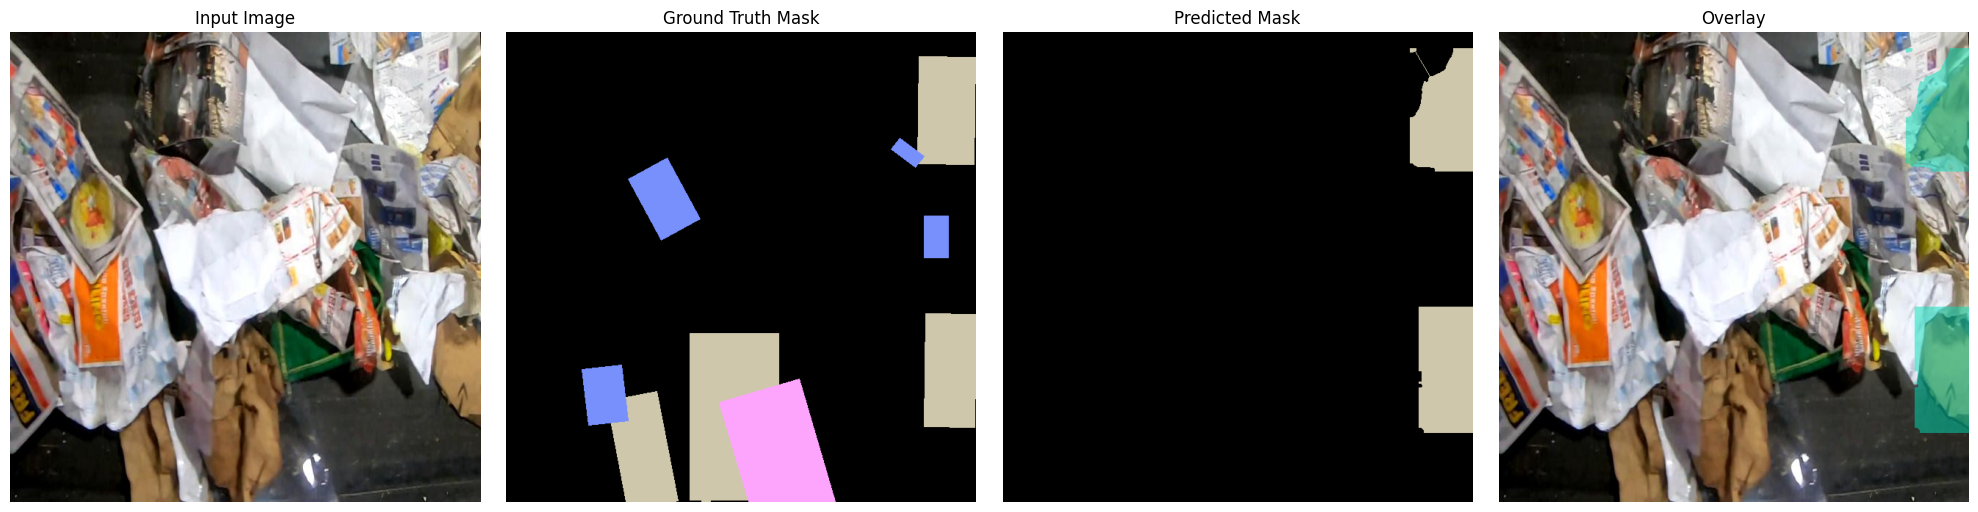


Sample 2: PET893_jpg.rf.1455e4bfacafe46b81f10babd548cb01.jpg
   Label file found.
   Model detected 1 objects.


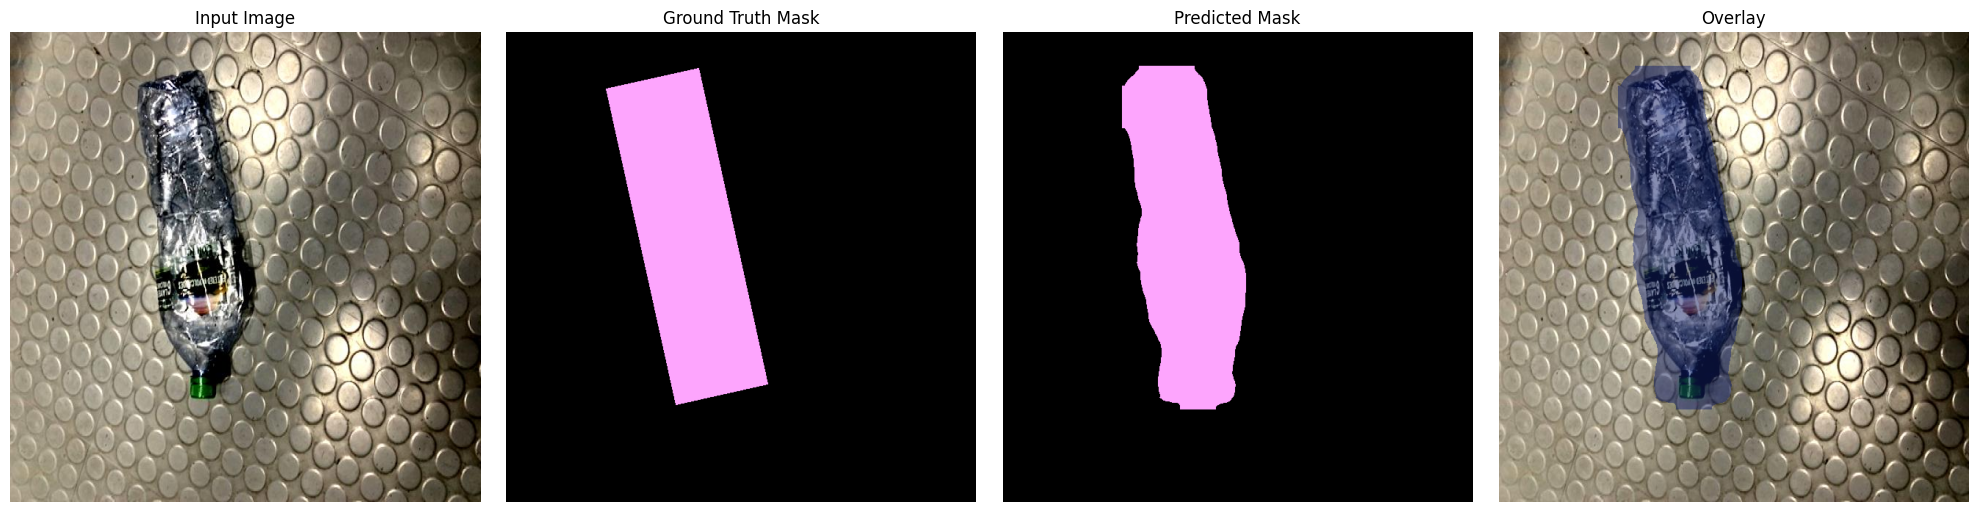


Sample 3: PET1-463_jpg.rf.3d5ffe0a7715a2c1c554f6daee2f6c63.jpg
   Label file found.
   Model detected 1 objects.


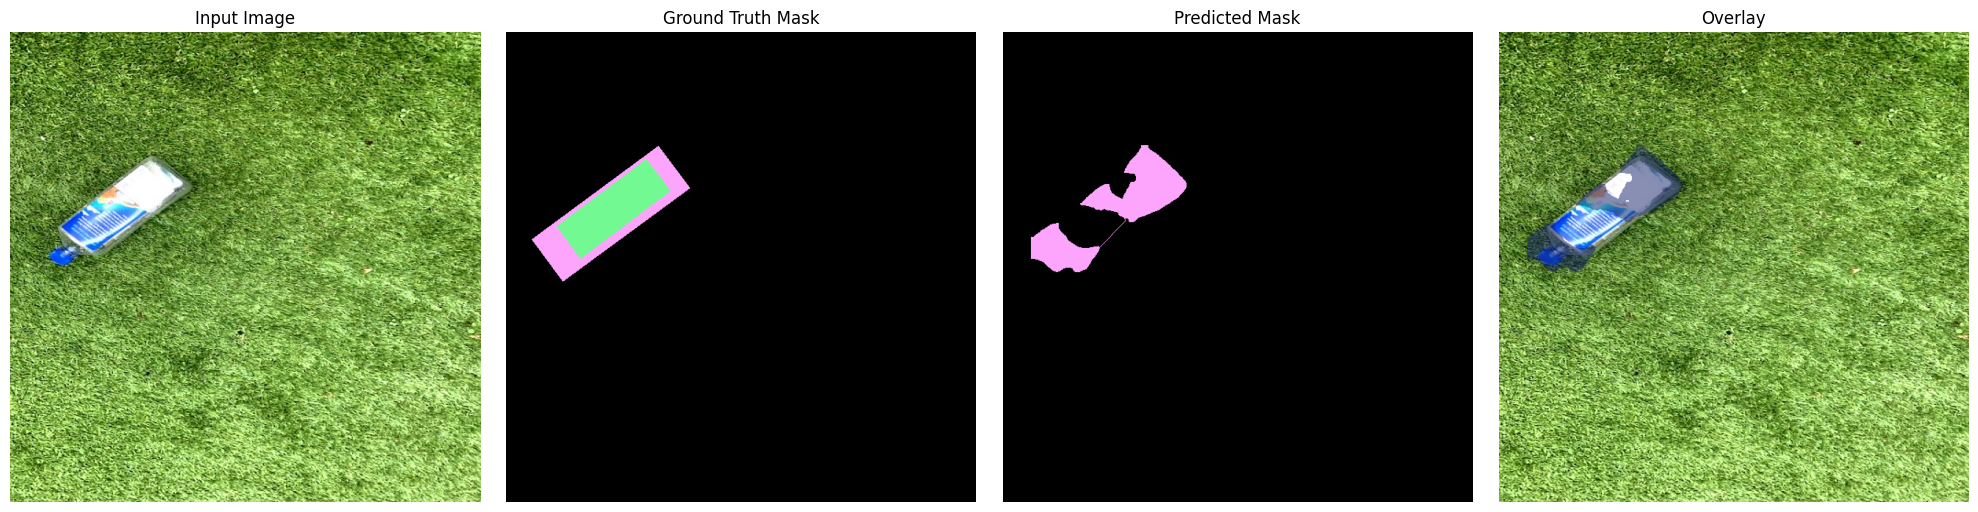


Sample 4: Glass164_jpg.rf.491698fd2d936a90911f827a68986725.jpg
   Label file found.
  Model predicted NOTHING.


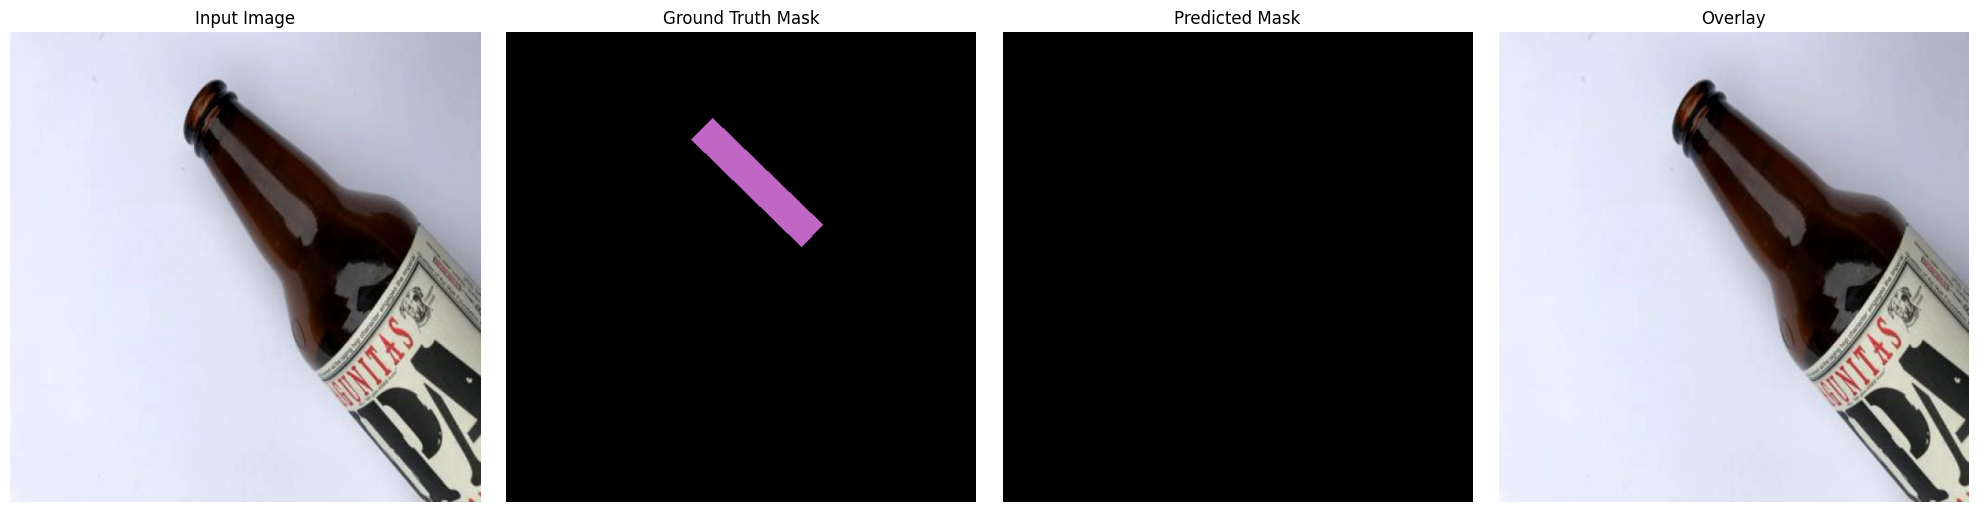

In [52]:
import os
import cv2
import glob
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ==========================================
#  CONFIGURATION
# ==========================================
MODEL_WEIGHTS = "/kaggle/working/fm_runs/fm_fixmatch_student/weights/best.pt"
DATA_YAML = "/kaggle/working/data.yaml"

# Use VALIDATION set (has labels)
IMG_DIR = "/kaggle/input/waste-detection/waste detection data/valid/images"

CONF_THRESH = 0.20  
NUM_SAMPLES = 4

# ==========================================
#  HELPER FUNCTIONS
# ==========================================
def get_colors(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    names = data['names']
    np.random.seed(42)
    colors = np.random.randint(100, 255, size=(len(names), 3), dtype=np.uint8).tolist()
    return names, colors

def get_ground_truth_mask(img_path, colors):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    lbl_path = img_path.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
    
    label_found = False
    if os.path.exists(lbl_path):
        label_found = True
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = list(map(float, line.strip().split()))
            cls_id = int(parts[0])
            coords = parts[1:]
            if len(coords) > 4: 
                points = np.array([[int(x*w), int(y*h)] for x, y in zip(coords[0::2], coords[1::2])], np.int32)
                points = points.reshape((-1, 1, 2))
                cv2.fillPoly(mask, [points], colors[cls_id])
    
    return img, mask, label_found, lbl_path

# ==========================================
# MAIN VISUALIZATION
# ==========================================
print(f" Loading model: {MODEL_WEIGHTS}")
model = YOLO(MODEL_WEIGHTS, task='segment')

names, colors = get_colors(DATA_YAML)

all_images = glob.glob(os.path.join(IMG_DIR, "*.*"))
if not all_images:
    print(f"Error: No images found in {IMG_DIR}")
else:
    print(f" Found {len(all_images)} images. Selecting {NUM_SAMPLES} samples...")
    samples = random.sample(all_images, min(len(all_images), NUM_SAMPLES))

    for i, img_path in enumerate(samples):
        # 1. Get Ground Truth
        orig_img, gt_mask, found, lbl_path = get_ground_truth_mask(img_path, colors)
        
        print(f"\nSample {i+1}: {os.path.basename(img_path)}")
        if not found:
            print(f"   Label file MISSING.")
        else:
            print(f"   Label file found.")

        # 2. Get Prediction
        results = model.predict(img_path, conf=CONF_THRESH, imgsz=640, verbose=False, task='segment')
        result = results[0]
        
        # Draw Prediction Mask
        h, w = orig_img.shape[:2]
        pred_mask = np.zeros((h, w, 3), dtype=np.uint8)
        
        if result.masks is None:
            print(f"  Model predicted NOTHING.")
        else:
            print(f"   Model detected {len(result.masks.xy)} objects.")
            for j, seg in enumerate(result.masks.xy):
                if len(seg) > 0:
                    cls_id = int(result.boxes.cls[j])
                    pts = np.array(seg, np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(pred_mask, [pts], colors[cls_id])

        # 3. Overlay (FIXED LINE BELOW)
        # REMOVED 'alpha=0.4' because your library version doesn't support it.
        overlay_bgr = result.plot(labels=True, boxes=False) 
        overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

        # 4. Plot
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        
        axs[0].imshow(orig_img)
        axs[0].set_title("Input Image")
        
        axs[1].imshow(gt_mask)
        axs[1].set_title("Ground Truth Mask")
        
        axs[2].imshow(pred_mask)
        axs[2].set_title(f"Predicted Mask")
        
        axs[3].imshow(overlay_rgb)
        axs[3].set_title("Overlay")
        
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()

# Quantitative Evaluation (Metrics)

In [54]:
import os
from ultralytics import YOLO

# ==========================================
# CONFIGURATION
# ==========================================
# We store the path in a variable first
MODEL_WEIGHTS = "/kaggle/working/fm_runs/fm_fixmatch_student/weights/best.pt"
DATA_YAML = "/kaggle/working/data.yaml"

# Fixed Print Statement
print(f" Loading model for metrics: {MODEL_WEIGHTS}")

# 1. Load Model
model = YOLO(MODEL_WEIGHTS, task='segment')

# 2. Run Validation
print("Calculating Metrics on Test Set...")
metrics = model.val(
    data=DATA_YAML,
    split='test',   
    imgsz=640,
    batch=8,
    conf=0.25,
    iou=0.6,
    device=0,
    verbose=False,
    task='segment'
)

# ==========================================
#  RESULTS
# ==========================================
print("\n" + "="*40)
print("      FIXMATCH SEGMENTATION RESULTS")
print("="*40)

if hasattr(metrics, 'seg'):
    print(f"• Mask mAP@0.5:      {metrics.seg.map50:.4f}")
    print(f"• Mask mAP@0.5:0.95: {metrics.seg.map:.4f}")
    print(f"• Precision (Mask):  {metrics.seg.mp:.4f}")
    print(f"• Recall (Mask):     {metrics.seg.mr:.4f}")
else:
    print("Error: Segmentation metrics not found.")
    print("Ensure the model was trained with task='segment'")

print("="*40)

 Loading model for metrics: /kaggle/working/fm_runs/fm_fixmatch_student/weights/best.pt
Calculating Metrics on Test Set...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO12n-seg summary (fused): 172 layers, 2,810,509 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.2±0.2 ms, read: 166.4±69.7 MB/s, size: 60.7 KB)
val: Scanning /kaggle/input/waste-detection/waste detection data/test/labels... 555 images, 192 backgrounds, 12 corrupt: 100% ━━━━━━━━━━━━ 744/744 1.1Kit/s 0.7s.1ss
val: /kaggle/input/waste-detection/waste detection data/test/images/08_frame_000511_PNG.rf.5282d48fc1870324fa1a08e73bb2b73b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1096]
val: /kaggle/input/waste-detection/waste detection data/test/images/08_frame_011800_PNG.rf.e0112d1214f8af88ce8d2b36ae3d4fe4.jpg: 3 duplicate labels removed
val: /kaggle/input/waste-detection/waste detection data/test/images/09_frame_003680_PNG

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        732       2125      0.617      0.394        0.5      0.407      0.598      0.383      0.481      0.327
Speed: 1.1ms preprocess, 4.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/segment/val4

      FIXMATCH SEGMENTATION RESULTS
• Mask mAP@0.5:      0.4807
• Mask mAP@0.5:0.95: 0.3268
• Precision (Mask):  0.5976
• Recall (Mask):     0.3829
